In [1]:
# Libraries used 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, classification_report
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from math import sqrt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-12-01 16:26:09.142351: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Upload the file 
Mdata = pd.read_csv('cleaned_earthquake_data.csv')

In [3]:
# Convert 'DateTime' column to datetime dtype
Mdata['DateTime'] = pd.to_datetime(Mdata['DateTime'])
# Filtering the data to include only years up to 2023
Mdata = Mdata[Mdata['DateTime'].dt.year <= 2023]
# Filtering out records with negative magnitudes
Mdata = Mdata[Mdata['mag'] >= 0]
# Filtering the data for valid longitude and latitude values
Mdata = Mdata[(Mdata['longitude'].between(-180, 180)) & (Mdata['latitude'].between(-90, 90))]
# Filtering out outliers in depth (removing values greater than 2000)
Mdata = Mdata[Mdata['depth'] <= 2000]

In [4]:
# Preprocessing for time series model
# Using only DateTime and magnitude for these models
# Aggregating and resampling the data
ts_df = Mdata[['DateTime', 'mag']].set_index('DateTime').resample('D').mean()
ts_df.fillna(method='ffill', inplace=True)

/var/folders/qm/6z6hsdq958b5_5kw6ns781xr0000gn/T/ipykernel_4829/3072310089.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts_df.fillna(method='ffill', inplace=True)


In [5]:
# Splitting the data into training and testing sets for time series model
train_size = int(len(ts_df) * 0.8)
train, test = ts_df[0:train_size], ts_df[train_size:len(ts_df)]

In [6]:
# LSTM model
# Preparing data for LSTM
train_lstm = np.array(train).reshape(-1, 1)
test_lstm = np.array(test).reshape(-1, 1)

In [7]:
# Feature Scaling for LSTM
scaler = StandardScaler()
train_lstm_scaled = scaler.fit_transform(train_lstm)
test_lstm_scaled = scaler.transform(test_lstm)

In [8]:
# Reshaping data for LSTM
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 100
X_train, y_train = create_dataset(train_lstm_scaled, time_step)
X_test, y_test = create_dataset(test_lstm_scaled, time_step)

In [9]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [10]:
# LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
lstm_model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=[early_stop])

lstm_predictions_scaled = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_rmse = sqrt(mean_squared_error(y_test, lstm_predictions[:,0]))

2023-12-01 17:06:09.958150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-01 17:06:09.959269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-01 17:06:09.959941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-12-01 17:06:10.516983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-01 17:06:10.517872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-01 17:06:10.518571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

558/558 [==============================] - 40s 68ms/step - loss: 0.1569
Epoch 2/100
558/558 [==============================] - 38s 68ms/step - loss: 0.1148
Epoch 3/100
558/558 [==============================] - 38s 68ms/step - loss: 0.1131
Epoch 4/100
558/558 [==============================] - 38s 68ms/step - loss: 0.1118
Epoch 5/100
558/558 [==============================] - 38s 69ms/step - loss: 0.1111
Epoch 6/100
558/558 [==============================] - 41s 74ms/step - loss: 0.1109
Epoch 7/100
558/558 [==============================] - 37s 66ms/step - loss: 0.1099
Epoch 8/100
558/558 [==============================] - 37s 65ms/step - loss: 0.1094
Epoch 9/100
558/558 [==============================] - 37s 66ms/step - loss: 0.1092
Epoch 10/100
558/558 [==============================] - 37s 66ms/step - loss: 0.1090
Epoch 11/100
558/558 [==============================] - 37s 66ms/step - loss: 0.1091
Epoch 12/100
558/558 [==============================] - 37s 67ms/step - loss: 0.1086
E

2023-12-01 18:08:07.560207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-01 18:08:07.561692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-01 18:08:07.562383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

277/277 [==============================] - 5s 15ms/step


In [11]:
print(lstm_rmse)

2.537746283542546


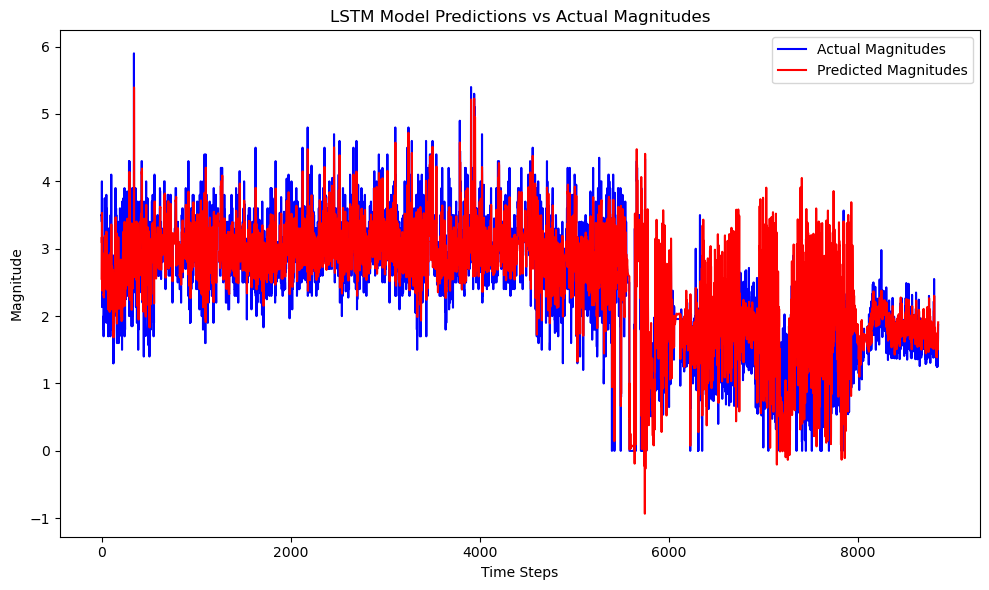

In [12]:
# Assuming y_test and lstm_predictions are the true values and LSTM model predictions respectively.
# Since y_test is scaled, it needs to be inverted to compare with the original magnitudes.
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE for the rescaled test data.
lstm_rmse_rescaled = sqrt(mean_squared_error(y_test_rescaled, lstm_predictions))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Magnitudes', color='blue')
plt.plot(lstm_predictions, label='Predicted Magnitudes', color='red')
plt.title('LSTM Model Predictions vs Actual Magnitudes')
plt.xlabel('Time Steps')
plt.ylabel('Magnitude')
plt.legend()
plt.tight_layout()
plt.show()